# Notebook to analyse AQUM model output for COVID-19 lockdown period

This notebook:
1. Retrieve data from MASS, read in data to cubelists and convert units
2. Plot timeseries of species concentrations and emissions sensitivity at sites
3. Plot spatial maps of species concentrations and emission sensitivity maps
4. Plot spatial maps of emissions (NH3 and NO)
5. Plot spatial maps and timeseries of met data (wind speed etc)
6. Calculate correlation coefficients between met data and concentrations/sensitivity coefficients
7. Calculate timeseries of Gas Ratio (GR) at specified sites

### Import modules


In [1]:
import sys
adaq_path = '/home/h01/bdrummon/code/adaq_python/trunk'
sys.path.append(adaq_path)
import adaqcode
import adaqscripts
import numpy as np
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import os
%matplotlib inline

### Notebook parameters

In [2]:
# Emissions factors for each scenario
ems_factors = [0.5, 0.3]
# Names of the scenario
scenarios = {'0.5x NOx' : '1c', '0.3x NOx' : '1d'}
# Sites to plot
sites = ['Auchencorth_Moss','Chilbolton_Observatory', 'London_Bloomsbury', 'Birmingham_Centre']

chem_species = ["NO", "NO2", "HNO3", "NH3", "PM2p5", "PM2p5_NH4NO3", "PM2p5_NH42SO4"]
met_variables = ["ws_10m", "wind_dir_10m", "total_precip", "T_1p5", "rh_1p5", "BL_depth"]

# DPI for saved images
DPI = 150

MASS_RETRIEVE = True

### Read some input files

In [3]:
# Read ini file
inifile = 'AQUM_analysis_nb.ini'
ini_dict = adaqcode.inifile.Inifile(inifile)

# Read sites
si = adaqcode.sites_info.SitesInfo()
sites_data = si.read_from_file('sites.txt', allsites=True)

# Check that plot directories exist - create them if not
for species in ini_dict['short_name_list']:
    if not os.path.isdir(ini_dict['plot_dir']+'/'+species):
        os.makedirs(ini_dict['plot_dir']+'/'+species)

Reading inifile AQUM_analysis_nb.ini
Number of sites:  4


/home/h01/bdrummon/code/adaq_python/trunk/adaqcode/sites_info.py:261: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(filename, dtype=None, names=True)


### Retrieve from MASS
- Retrieve pp files from MASS using inifile parameters

In [ ]:
if MASS_RETRIEVE:
    adaqscripts.aq_mass_retrieve.mass_retrieval(inifilename=inifile)

### Load the model data and convert units
This takes a few minutes!

In [4]:
md_list = adaqcode.adaq_functions.get_models(ini_dict, sites_data, surface_only=True)
# Convert units (empty observations list)
od, md_list = adaqcode.adaq_functions.unit_conversion(adaqcode.adaq_data.ADAQData(), md_list,
                                            chem_units=ini_dict.get('chem_units', 'ug/m3'),
                                            aerosol_units=ini_dict.get('aerosol_units', 'ug/m3'))

Getting model data for  Control  at  2020-10-19 15:01:29.501242


/opt/scitools/environments/default/current/lib/python3.6/site-packages/iris/fileformats/rules.py:334: UserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(msg.format(factory=factory_name))


Getting model data for  0.5x NOx  at  2020-10-19 15:03:20.665486
Getting model data for  0.3x NOx  at  2020-10-19 15:05:16.512223


/net/home/h01/bdrummon/code/adaq_python/trunk/adaqcode/cube_chemistry.py:123: UserWarning: Not converting units for atmosphere_boundary_layer_thickness
  warnings.warn('Not converting units for ' + cubename)
/net/home/h01/bdrummon/code/adaq_python/trunk/adaqcode/cube_chemistry.py:123: UserWarning: Not converting units for precipitation_amount
  warnings.warn('Not converting units for ' + cubename)
/net/home/h01/bdrummon/code/adaq_python/trunk/adaqcode/cube_chemistry.py:123: UserWarning: Not converting units for relative_humidity
  warnings.warn('Not converting units for ' + cubename)
/net/home/h01/bdrummon/code/adaq_python/trunk/adaqcode/cube_chemistry.py:123: UserWarning: Not converting units for wind_speed
  warnings.warn('Not converting units for ' + cubename)
/net/home/h01/bdrummon/code/adaq_python/trunk/adaqcode/cube_chemistry.py:123: UserWarning: Not converting units for wind_to_direction
  warnings.warn('Not converting units for ' + cubename)


### Functions to load emissions cubes
Note: the files are copied to scratch from HPC

In [ ]:
def load_ukca_emission():
    cubes = iris.load('/scratch/bdrummon/qrclim.ukca.surf.NO.nc')

    # Sum sectors
    cube = sum(cubes)[3,0,:,:]
    cube.attributes['short_name'] = 'NO Emissions'
    cube.long_name = 'NO emission rate'

    return cube

In [ ]:
def load_classic_emission():
    cubes = iris.load('/scratch/bdrummon/qrclim.sulpsurf')
    cube = cubes.extract('tendency_of_atmosphere_mass_content_of_ammonia_expressed_as_nitrogen_due_to_emission')[0][3,:,:]
    cube.attributes['short_name'] = 'NH3 Emissions'
    cube.long_name = 'NH3 emission rate'
    
    return cube

## Timeseries of emission sensitivity at sites
Extract model data at selected sites, calculate the emission sensitivity factor and plot as a timeseries

In [ ]:
for species in ini_dict['short_name_list']:
    
    if species in chem_species:
    
        for site in sites:

            # Initialise time series
            tsp = adaqcode.timeseries_plot.TimeSeriesPlot()

            # Get control
            md_site_ctl = md_list[0].extract(site_name=site, short_name=species, singlecube=True)

            # Get experiment cube lists
            md_site_exp = md_list[1:]

            for md, ems_factor, scenario in zip(md_site_exp, ems_factors, scenarios):
                md_site = md.extract(site_name=site, short_name=species, singlecube=True)
                ems_factor = (md_site_ctl - md_site)/md_site_ctl/(1.-ems_factor)
                ems_factor.units = 'no unit'
                ems_factor.long_name = 'Emissions Sensitivity Factor'
                ems_factor.attributes['label'] = scenario
                tsp.add_line(ems_factor)


            fig = tsp.plot()
            plt.savefig(ini_dict['plot_dir']+'/'+species+'/'+site+'_emission_sensitivity_timeseries.png', dpi=DPI)

## Plot timeseries of concentrations
Extract model data at selected sites and plot as a timeseries

In [ ]:
for species in ini_dict['short_name_list']:
    
        for site in sites:

            # Initialise time series
            tsp = adaqcode.timeseries_plot.TimeSeriesPlot()

            # Get control
            md_site_ctl = md_list[0].extract(site_name=site, short_name=species, singlecube=True)
            tsp.add_line(md_site_ctl)

            # Get experiment cube lists
            md_site_exp = md_list[1:]
            
            # If chemistry species add lines for experiments
            if species in chem_species:

                for md, ems_factor, scenario in zip(md_site_exp, ems_factors, scenarios):
                    md_site = md.extract(site_name=site, short_name=species, singlecube=True)
                    tsp.add_line(md_site)

            fig = tsp.plot()
            plt.savefig(ini_dict['plot_dir']+'/'+species+'/'+site+'_variable_timeseries.png', dpi=DPI)

## Spatial maps of emission sensitivity
- Calculate the emission sensitivity and plot as a 2D map
- Model concentrations are aggregated first by taking a mean over time

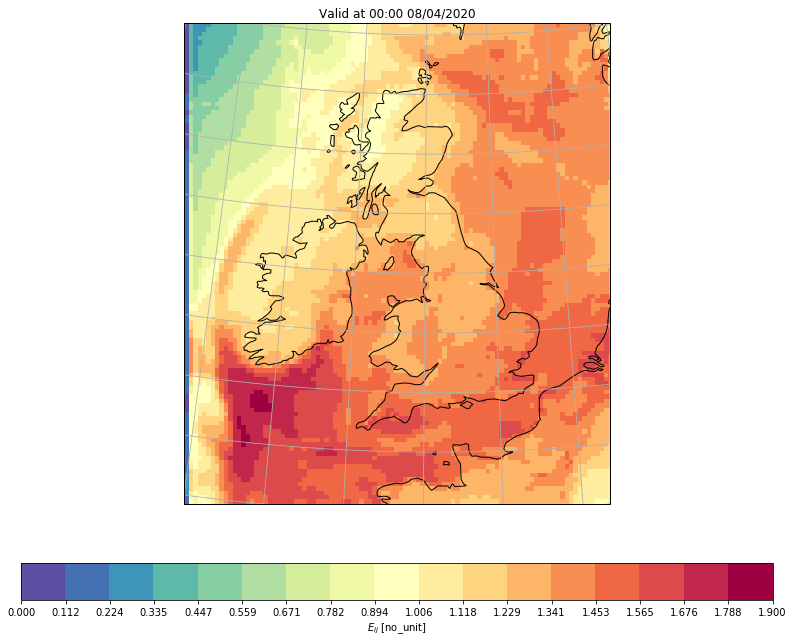

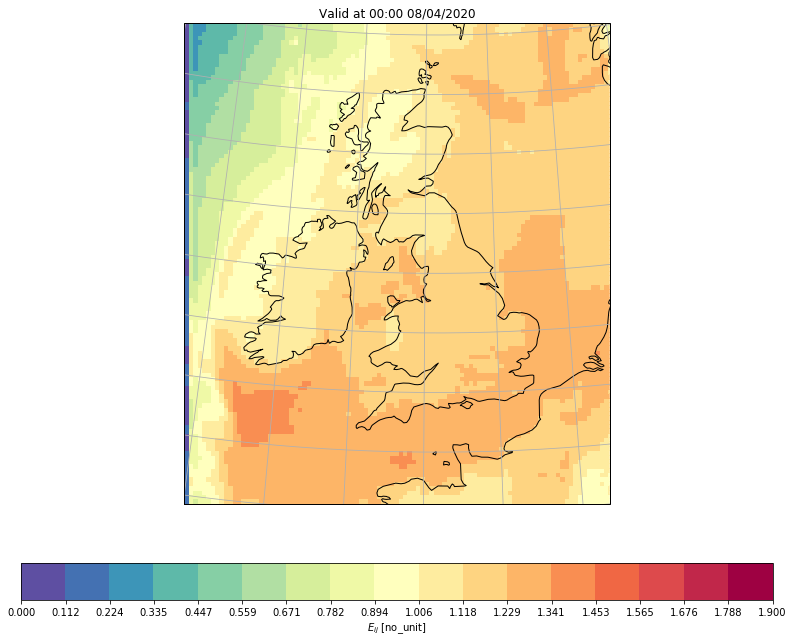

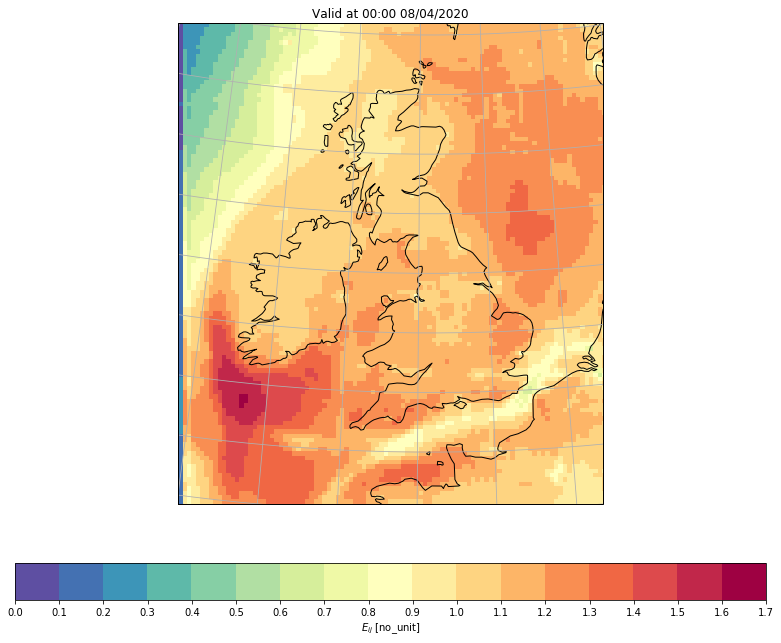

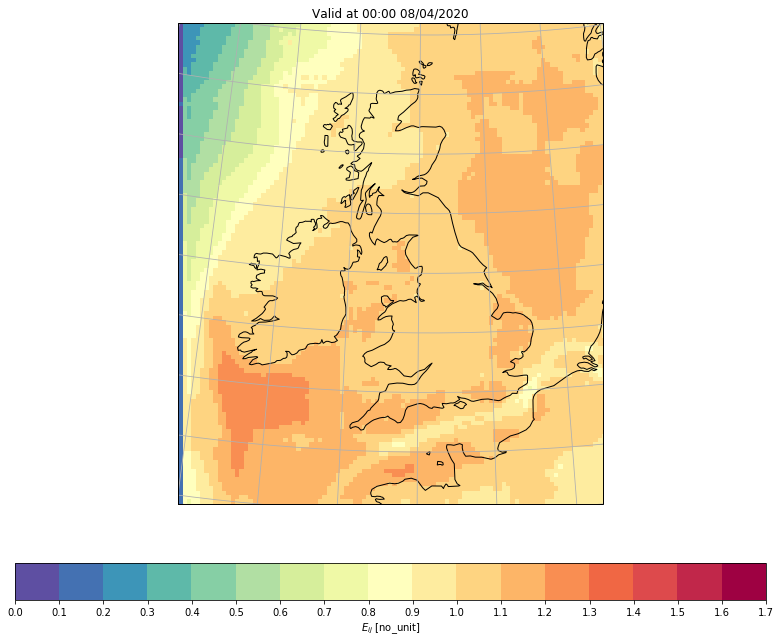

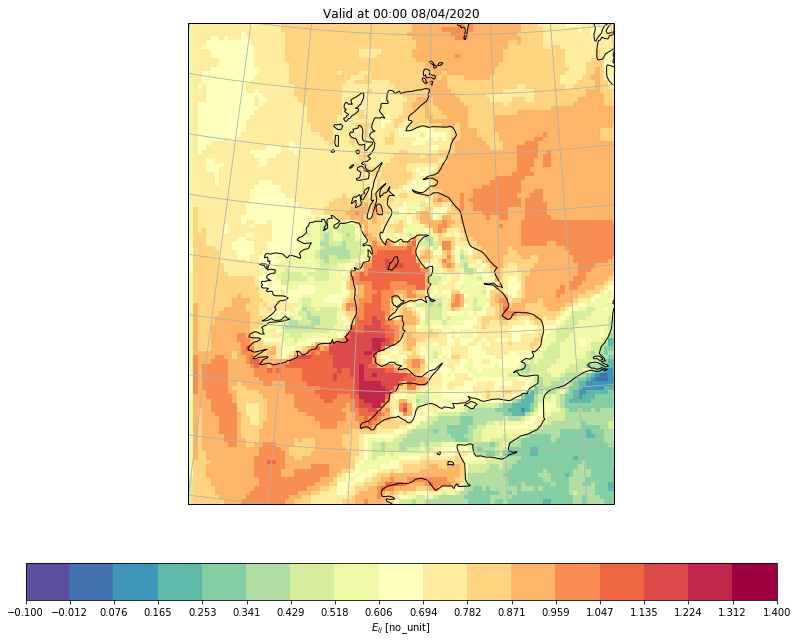

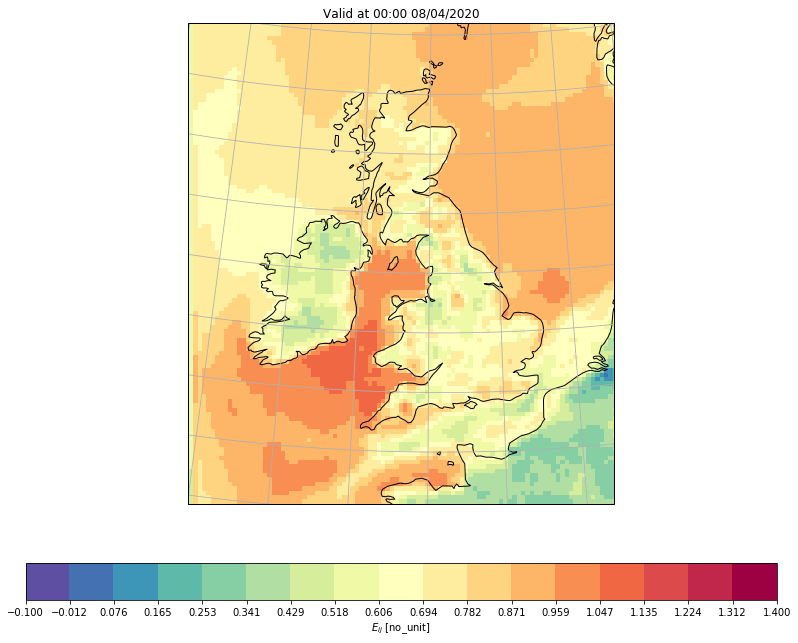

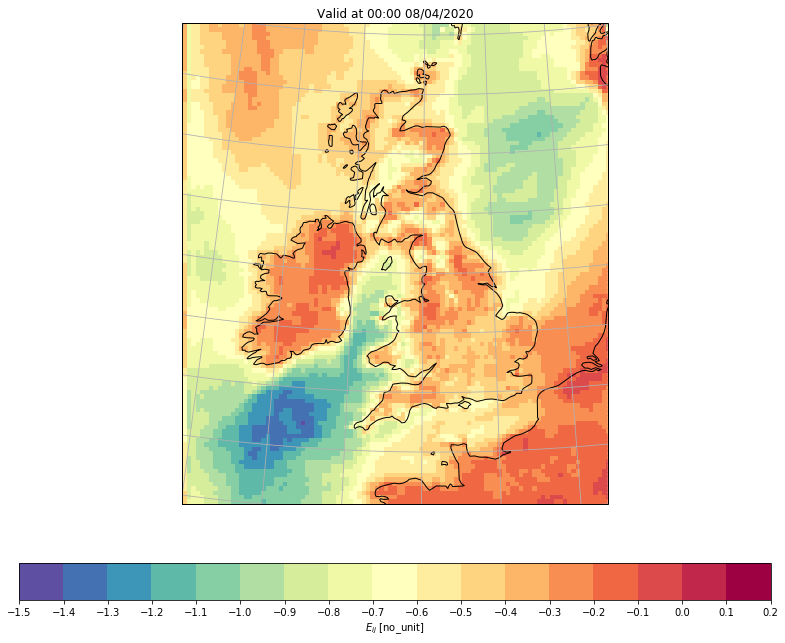

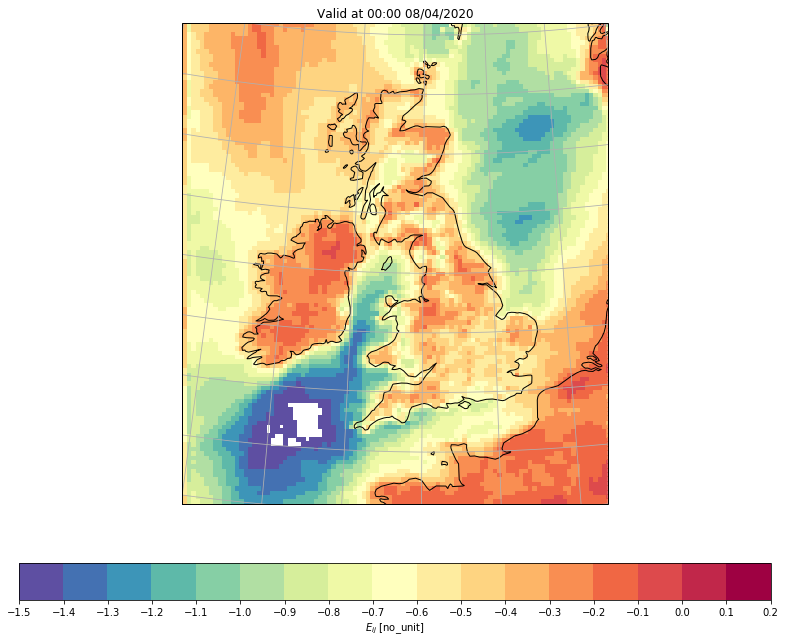

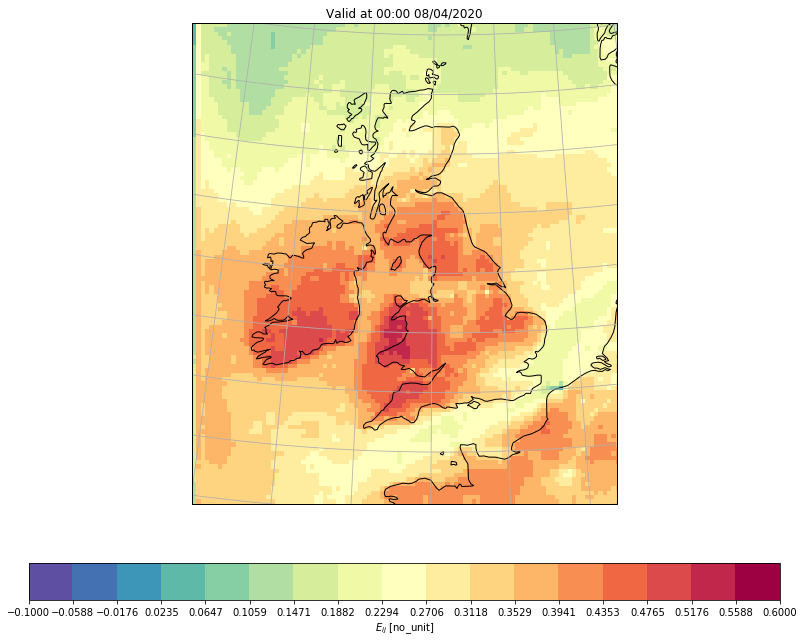

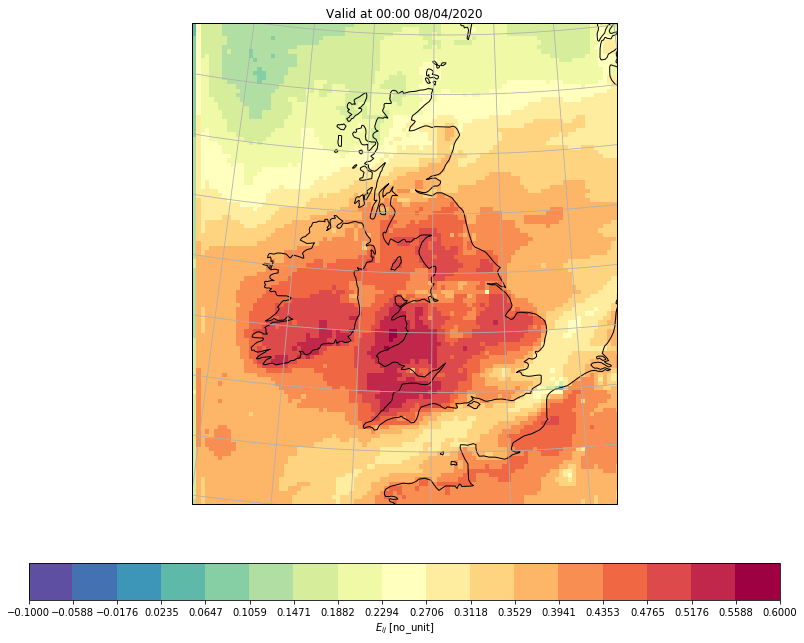

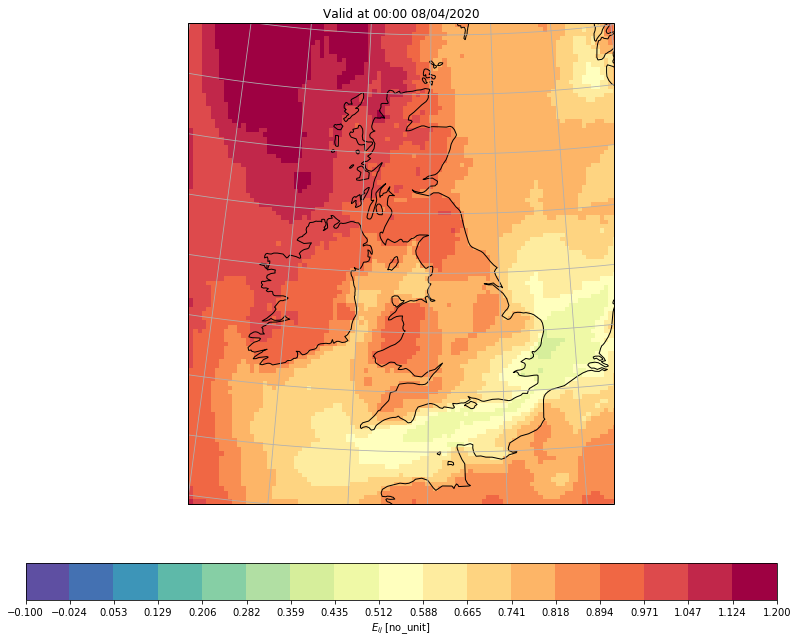

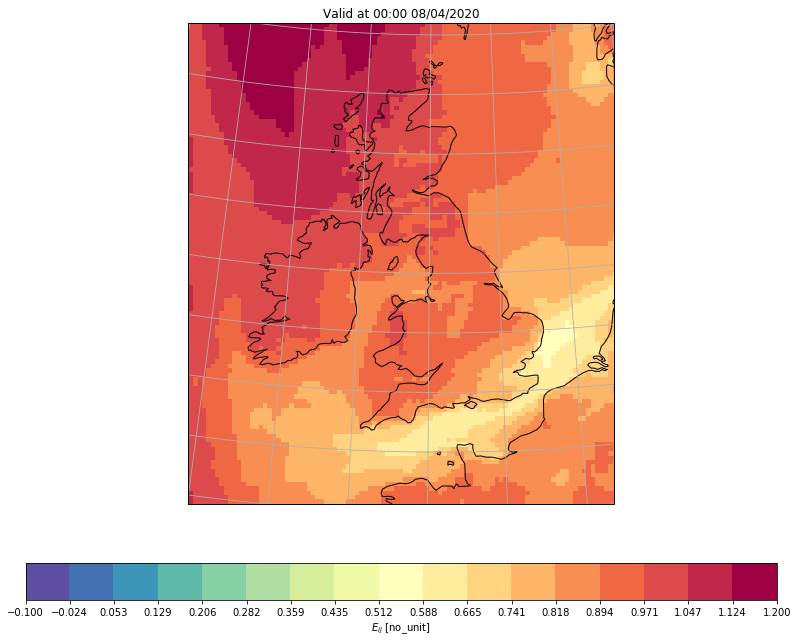

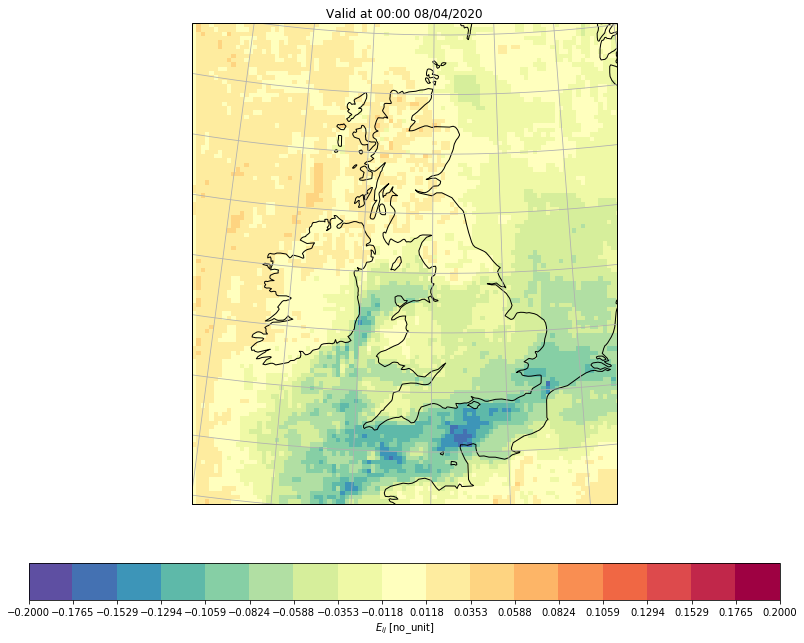

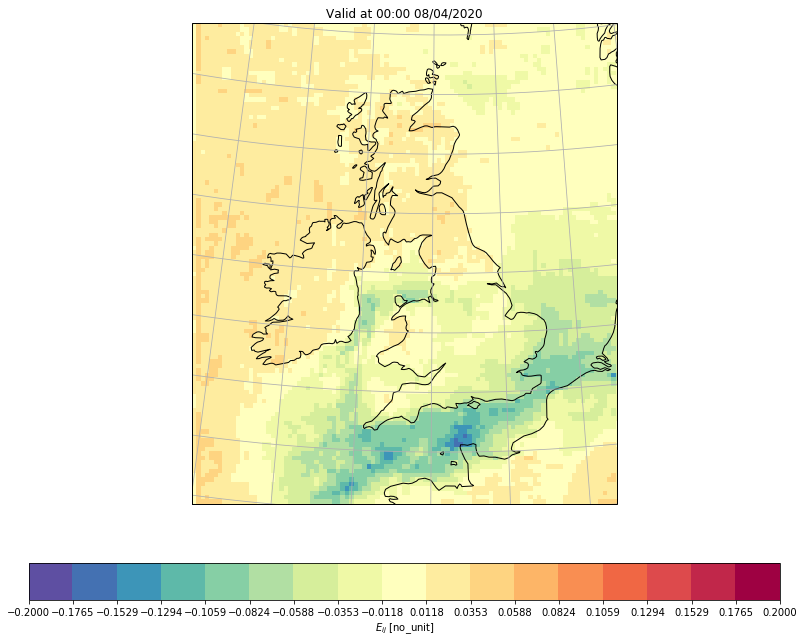

In [7]:
levels_dict = {
    'PM2p5' : np.linspace(-0.1, 0.6, 18),
    'PM2p5_NH4NO3' : np.linspace(-0.1, 1.2, 18),
    'PM2p5_NH42SO4' : np.linspace(-0.2, 0.2, 18),
    'NH3' : np.linspace(-1.5, 0.2, 18),
    'HNO3' : np.linspace(-0.1, 1.4, 18),
    'NO2' : np.linspace(0., 1.7, 18),
    'NO' : np.linspace(0., 1.9, 18)
}

for species in chem_species:    

    # Get control
    md_ctl = md_list[0].gridded_cube_list.extract(iris.AttributeConstraint(short_name=species))[0]
    md_ctl = md_ctl.collapsed('time', iris.analysis.MEAN)

    # Get experiment cube lists
    md_exp = md_list[1:]
    
    # Calculate emission sensitivity factor and modify metadata
    for md, ems_factor, scenario in zip(md_exp, ems_factors, scenarios):
        md_sp = md.gridded_cube_list.extract(iris.AttributeConstraint(short_name=species))[0]
        md_sp = md_sp.collapsed('time', iris.analysis.MEAN)
        ems_factor = (md_ctl - md_sp)/md_ctl/(1.-ems_factor)
        ems_factor.units = 'no unit'
        ems_factor.long_name = 'Emissions Sensitivity Factor'
        ems_factor.attributes['short_name'] = r'$E_{ij}$'
        ems_factor.attributes['label'] = scenario
        
        # Create field layer
        fl = adaqcode.field_layer.FieldLayer(ems_factor)
        fl.set_layerstyle(levels=levels_dict[species], plottype='pcolormesh', mask=True, autozoom=False, colorscale='linear', cmap='Spectral_r')
        np.set_printoptions(formatter={'float':lambda x: '{:5.2e}'.format(x)})
        
        # Create figure
        fp = adaqcode.field_plot.FieldPlot(ini_dict)
        fp.add_layer(fl)
        fp.setup_mapping(extent=[-12, 4.0, 48., 60.], mapping='coastlines', gridlines=True)
        fig = fp.plot()
        plt.savefig(ini_dict['plot_dir']+'/'+species+'/'+scenarios[scenario]+'_emission_sensitivity_gridded_field.png', dpi=DPI)

## Spatial maps of species concentrations
- Plot temporal means of species concentrations 

In [ ]:
# Dictionary defining contour levels
levels_dict = {
    'PM2p5' : np.linspace(0., 30., 12),
    'PM2p5_NH4NO3' : np.linspace(0., 25., 12),
    'PM2p5_NH42SO4' : np.linspace(0., 8., 12),
    'NH3' : np.linspace(0., 15., 12),
    'HNO3' : np.linspace(0., 6., 12),
    'NO2' : np.linspace(0., 40., 12),
    'NO' : np.linspace(0., 20., 12)
}

for species in ini_dict['short_name_list']:    

    if species in chem_species:
    
        # Get control
        md_ctl = md_list[0].gridded_cube_list.extract(iris.AttributeConstraint(short_name=species))[0]
        md_ctl = md_ctl.collapsed('time', iris.analysis.MEAN)

        fl = adaqcode.field_layer.FieldLayer(md_ctl)
        fl.set_layerstyle(nlevels=12, levels=levels_dict[species], plottype='pcolormesh', mask=True, autozoom=False, colorscale='linear', cmap=adaqcode.aq_indices.daqi_cmap())
        np.set_printoptions(formatter={'float':lambda x: '{:5.2e}'.format(x)})

        # Create figure
        fp = adaqcode.field_plot.FieldPlot(ini_dict)
        fp.add_layer(fl)
        fp.setup_mapping(extent=[-12, 4.0, 48., 60.], mapping='coastlines', gridlines=True)
        fig = fp.plot()
        plt.savefig(ini_dict['plot_dir']+'/'+species+'/control_gridded_field_conc.png', dpi=DPI)

        # Get experiment cube lists
        md_exp = md_list[1:]

        # Calculate emission sensitivity factor and modify metadata
        for md, scenario in zip(md_exp, scenarios):
            md_sp = md.gridded_cube_list.extract(iris.AttributeConstraint(short_name=species))[0]
            md_sp = md_sp.collapsed('time', iris.analysis.MEAN)

            # Create field layer
            fl = adaqcode.field_layer.FieldLayer(md_sp)
            fl.set_layerstyle(nlevels=12, levels=levels_dict[species], plottype='pcolormesh', mask=True, autozoom=False, colorscale='linear', cmap=adaqcode.aq_indices.daqi_cmap())
            np.set_printoptions(formatter={'float':lambda x: '{:5.2e}'.format(x)})

            # Create figure
            fp = adaqcode.field_plot.FieldPlot(ini_dict)
            fp.add_layer(fl)
            fp.setup_mapping(extent=[-12, 4.0, 48., 60.], mapping='coastlines', gridlines=True)
            fig = fp.plot()
            plt.savefig(ini_dict['plot_dir']+'/'+species+'/'+scenarios[scenario]+'_concentration_gridded_field.png', dpi=DPI)

## Spatial maps of Met variables

In [ ]:
# Dictionary defining contour levels
levels_dict = {
    'ws_10m' : np.linspace(0., 20., 12),
    'wind_dir_10m' : np.linspace(0.,360., 12),
    'total_precip' : np.linspace(0., 100., 12),
    'T_1p5' : np.linspace(275., 288., 12),
    'rh_1p5' : np.linspace(50., 100., 12),
    'BL_depth' : np.linspace(0., 1000., 12)
}
# Dictionary defining contour colours
cmap_dict = {
    'ws_10m' : 'GnBu',
    'wind_dir_10m' : 'GnBu',
    'total_precip' : 'GnBu',
    'T_1p5' : 'coolwarm',
    'rh_1p5' : 'GnBu',
    'BL_depth' : 'GnBu'
}

# Plot met variables
for var in met_variables:

    md_ctl = md_list[0].gridded_cube_list.extract(iris.AttributeConstraint(short_name=var))[0]
    if var in ['total_precip']:
        md_ctl = md_ctl.collapsed('time', iris.analysis.SUM)
    else:
        md_ctl = md_ctl.collapsed('time', iris.analysis.MEAN)
    
    fl = adaqcode.field_layer.FieldLayer(md_ctl)
    fl.set_layerstyle(nlevels=12, levels=levels_dict[var], plottype='pcolormesh', mask=True, autozoom=False, colorscale='linear', cmap=cmap_dict[var])
    np.set_printoptions(formatter={'float':lambda x: '{:5.2e}'.format(x)})

    # Create figure
    fp = adaqcode.field_plot.FieldPlot(ini_dict)
    fp.add_layer(fl)
    fp.setup_mapping(extent=[-12, 4.0, 48., 60.], mapping='coastlines', gridlines=True)
    fig = fp.plot()
    plt.savefig(ini_dict['plot_dir']+'/'+var+'/control_'+var+'_gridded_field.png', dpi=DPI)

## Plot surface emissions of ammonia and NO

In [ ]:
cube = load_ukca_emission()
fl = adaqcode.field_layer.FieldLayer(cube)
fl.set_layerstyle(nlevels=12, plottype='pcolormesh', mask=True, autozoom=False, colorscale='log', cmap='YlGnBu')
np.set_printoptions(formatter={'float':lambda x: '{:5.2e}'.format(x)})

# Create figure
fp = adaqcode.field_plot.FieldPlot(ini_dict)
fp.add_layer(fl)
fp.setup_mapping(extent=[-12, 4.0, 48., 60.], mapping='coastlines', gridlines=True)
fig = fp.plot()
plt.savefig(ini_dict['plot_dir']+'/April_nitric_oxide_emissions.png', dpi=DPI)

cube = load_classic_emission()
fl = adaqcode.field_layer.FieldLayer(cube)
fl.set_layerstyle(nlevels=12, plottype='pcolormesh', mask=True, autozoom=False, colorscale='log', cmap='YlGnBu')
np.set_printoptions(formatter={'float':lambda x: '{:5.2e}'.format(x)})

# Create figure
fp = adaqcode.field_plot.FieldPlot(ini_dict)
fp.add_layer(fl)
fp.setup_mapping(extent=[-12, 4.0, 48., 60.], mapping='coastlines', gridlines=True)
fig = fp.plot()
plt.savefig(ini_dict['plot_dir']+'/April_ammonia_emissions.png', dpi=DPI)

# Calculate correlation coefficients

- The cells below calculate the correlation coefficient between various model quantities
- Output to csv files

## Timeseries at sites
Calculate correlation between species surface concentration and meteorological parameters

In [ ]:
f = open(ini_dict['plot_dir']+'/site_concentration_met_correlations.csv', "w")
for site in sites:
    f.write(site+', \n')
    for species in chem_species:
        
        # Species concentration
        md_site = md_list[0].extract(site_name=site, short_name=species, singlecube=True)
        
        f.write(species+', \n')
        
        for var in met_variables:
            
            # Met Variable
            met_site = md_list[0].extract(site_name=site, short_name=var, singlecube=True)
            
            if md_site.data.size == met_site.data.size:
                f.write(var+', '+str(np.corrcoef(md_site.data, met_site.data)[0,1])+'\n')
            
f.close()  
        

Calculate correlation between species emission sensitivity and meteorological parameters

In [ ]:
f = open(ini_dict['plot_dir']+'/site_emission_sensitivity_met_correlations.csv', "w")
for site in sites:
    f.write(site+', \n')
    for species in chem_species:
        
        # Species concentration
        md_site = md_list[0].extract(site_name=site, short_name=species, singlecube=True)
        md_exp  = md_list[1].extract(site_name=site, short_name=species, singlecube=True)
        
        ems_sens = (md_site - md_exp)/md_site/(1.-0.5)
        
        f.write(species+', \n')
        
        for var in met_variables:
            
            # Met Variable
            met_site = md_list[0].extract(site_name=site, short_name=var, singlecube=True)
            
            if ems_sens.data.size == met_site.data.size:
                                
                f.write(var+', '+str(np.ma.corrcoef(np.ma.masked_invalid(ems_sens.data), met_site.data)[0,1])+'\n')
            
f.close()  

## Temporal mean at surface 
Calculate correlation of emission sensitivity with surface emissions 

In [ ]:
f = open(ini_dict['plot_dir']+'/emission_sensitivity_emission_correlations.csv', "w")
for species in chem_species:
    # Species concentration
    md_ctl = md_list[0].gridded_cube_list.extract(iris.AttributeConstraint(short_name=species))[0]
    md_ctl = md_ctl.collapsed('time', iris.analysis.MEAN)
    
    md_exp = md_list[1].gridded_cube_list.extract(iris.AttributeConstraint(short_name=species))[0]
    md_exp = md_exp.collapsed('time', iris.analysis.MEAN)
        
    ems_sens = (md_ctl - md_exp)/md_ctl/(1.-0.5)
            
    # Load emissions
    ems = load_ukca_emission()
    
    if ems_sens.data.size == ems.data.size:
                                
        f.write(species+', '+str(np.ma.corrcoef(np.ma.masked_invalid(ems_sens.data.flatten()), ems.data.flatten())[0,1])+'\n')

f.close()

f = open(ini_dict['plot_dir']+'/emission_sensitivity_nh3_emission_correlations.csv', "w")
for species in chem_species:
    # Species concentration
    md_ctl = md_list[0].gridded_cube_list.extract(iris.AttributeConstraint(short_name=species))[0]
    md_ctl = md_ctl.collapsed('time', iris.analysis.MEAN)
    
    md_exp = md_list[1].gridded_cube_list.extract(iris.AttributeConstraint(short_name=species))[0]
    md_exp = md_exp.collapsed('time', iris.analysis.MEAN)
        
    ems_sens = (md_ctl - md_exp)/md_ctl/(1.-0.5)
            
    # Load emissions
    ems = load_classic_emission()
    
    if ems_sens.data.size == ems.data.size:
                                
        f.write(species+', '+str(np.ma.corrcoef(np.ma.masked_invalid(ems_sens.data.flatten()), ems.data.flatten())[0,1])+'\n')

f.close()

Calculate correlation of emission sensitivity with meteorological variables

In [ ]:
f = open(ini_dict['plot_dir']+'/spatial_emission_sensitivity_met_correlations.csv', "w")
for species in chem_species:
    # Species concentration
    md_ctl = md_list[0].gridded_cube_list.extract(iris.AttributeConstraint(short_name=species))[0]
    md_ctl = md_ctl.collapsed('time', iris.analysis.MEAN)
    
    md_exp = md_list[1].gridded_cube_list.extract(iris.AttributeConstraint(short_name=species))[0]
    md_exp = md_exp.collapsed('time', iris.analysis.MEAN)
        
    ems_sens = (md_ctl - md_exp)/md_ctl/(1.-0.5)

    f.write(species+', \n')

    # Load emissions
    for met in met_variables:
        
        md_met = md_list[0].gridded_cube_list.extract(iris.AttributeConstraint(short_name=met))[0]
        md_met = md_met.collapsed('time', iris.analysis.MEAN)
    
        if ems_sens.data.size == md_met.data.size:
                                
            f.write(met+', '+str(np.ma.corrcoef(np.ma.masked_invalid(ems_sens.data.flatten()), md_met.data.flatten())[0,1])+'\n')

f.close()

## Calculate Gas Ratio (GR)
Calculate and plot the Gas Ratio (GR) at different sites

Note we need to express abundances in terms of number rather than mass

adaq_python already includes a function to convert gas species to ppb, but not for aerosol species

For the mole fraction of aerosol species, this is the fraction of molecules, not the fraction of aerosol particles

In [ ]:
# Some constants
# Molar masses 
AEROSOL = {'PM2p5_NH4NO3' : 80.043,
           'PM2p5_NH42SO4': 132.14}
# Standard temperature and pressure and molar gas constant
STD_TEMP = 273.15
STD_PRES = 1e5
RGAS = 8.314

# Convert units to VMR
od, md_list_vmr = adaqcode.adaq_functions.unit_conversion(adaqcode.adaq_data.ADAQData(), md_list,
                                            chem_units=ini_dict.get('chem_units', 'ppb'),
                                            aerosol_units=ini_dict.get('aerosol_units', 'ug/m3'))
# Convert aerosol units to ppb
for md in md_list_vmr:
    scl = md.sites_cube_list
    for cube in scl:
        short_name = cube.attributes['short_name']
        if short_name in AEROSOL:
            cube.data = cube.data * 1e3 * RGAS * STD_TEMP / (STD_PRES * AEROSOL[short_name])
            cube.units = 'ppb'

In [ ]:
names = ['control', '1c', '1d']
# Calculate GR for each site
for md, name in zip(md_list, names):
    for site in sites:
        cubes = md.extract(site_name=site).sites_cube_list

        # Get cubes for individual species
        nh3 = cubes.extract(iris.AttributeConstraint(short_name='NH3'))[0]
        nh4no3 = cubes.extract(iris.AttributeConstraint(short_name='PM2p5_NH4NO3'))[0]
        nh42so4 = cubes.extract(iris.AttributeConstraint(short_name='PM2p5_NH42SO4'))[0]
        hno3 = cubes.extract(iris.AttributeConstraint(short_name='HNO3'))[0]
        
        # Derive NH4+ mole fraction
        nh4 = 2.*nh42so4 + nh4no3

        # Calculate GR and plot
        GR = (nh3 + nh4 - 2.*nh42so4)/(hno3+nh4no3)
        qplt.plot(GR)
        
        # Add lines at 1 and 0 - copy GR cube for ease
        ones = GR.copy()
        ones.data = np.ones(ones.data.size)
        zeros = GR.copy()
        zeros.data = np.zeros(zeros.data.size)
        qplt.plot(ones)
        qplt.plot(zeros)
        
        # Setup and plot
        plt.title(site)
        plt.ylabel('Gas Ratio')
        plt.ylim(-1.,20)
        plt.plot()
        plt.savefig(ini_dict['plot_dir']+'/GR/'+name+'_'+site+'.png', dpi=DPI)
        plt.clf()